In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pylab 

pylab.rcParams['figure.figsize'] = (16.0, 14.0)

import psycopg2
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.collections import LineCollection
#import pyproj.Proj as proj

import numpy as np

#from shapely import wkb

from osgeo import gdal
from osgeo import ogr
gdal.UseExceptions()

import time
import base64

In [4]:
def loadGeotiffAsMaskedArray(filename, band=1):
    t = time.time()
    print "Opening " + filename
    #Open using GDAL
    ds = gdal.Open(filename)
    band = ds.GetRasterBand(band)
    arr = np.ma.masked_array(band.ReadAsArray())
    
    #Compute extent for printing
    geoTransform = ds.GetGeoTransform()
    xres = ds.RasterXSize
    yres = ds.RasterYSize
    xmin = geoTransform[0]
    ymax = geoTransform[3]
    xmax = xmin + geoTransform[1]*xres
    ymin = ymax + geoTransform[5]*yres
    print "Geotiff size: " + str(arr.shape) + ", extent: " + str([xmin, xmax, ymin, ymax])

    #Remove no-data values
    no_data_value = band.GetNoDataValue()
    
    if (no_data_value):
        arr[arr == no_data_value] = np.ma.masked
        
    return arr

In [5]:
def sqlToGeotiff(connstring, sql, outfilename):
    
    #Connect and send query
    t = time.time()
    conn = psycopg2.connect(connstring)
    curs = conn.cursor()
    curs.execute(sql)
    elapsed = time.time() - t
    print "SQL query took " + str(elapsed) + " seconds"
    
    #Retrieve SQL results
    record = curs.fetchone()
    data = bytes(record[0])
    print "Data size: " + str(len(data)/(1024*1024)) + " Mb"
    
    #Close connection
    conn.close()
    
    #Save to disk
    with open(outfilename, "wb") as outfile:
        outfile.write(data)
        
    print "Wrote " + outfilename + ", elapsed = " + str(time.time() - t)

In [6]:
def previewArray(arr):
    # Create colormap
    c = plt.get_cmap('terrain');
    c.set_bad(color='k', alpha=0.0)
    
    #Plot
    plt.imshow(arr, cmap=c)

In [7]:
def previewGeotiff(filename):
    arr = loadGeotiffAsMaskedArray(filename)
    
    #arr = np.ma.masked_equal(arr, 0.0)
    #arr[arr > 50] = np.nan; #Remove "high altitude"
    
    num_elements = np.sum(np.isfinite(arr));
    print str(num_elements / 1000000) + "M active elements (" + str(num_elements) + ")"
    
    # Close and clean up
    ds = None
    band = None
    
    previewArray(arr)

In [8]:
bboxSql = """WITH bbox AS (
  SELECT 
    ST_MakeEnvelope(210000, 6650000, 250000, 6690000, ST_SRID(rast)) AS geom, --501x501
    ST_Clip(rast, ST_Centroid(ST_Envelope(rast)), true) as rast
  from
    n50.norges_raster
  LIMIT 1
 )"""

In [10]:
connstring = "host='127.0.0.1' dbname='n50' user='postgres' password='postgres'"

sql = bboxSql + """
 SELECT
  ST_AsTiff(ST_Union(ST_Clip(raster.rast, bbox.geom, true)))
 FROM 
  n50.norges_raster as raster,
  bbox
 WHERE
  raster.rast::geometry && GEOM
"""


outfilename = 'anders_hoh.tiff'
sqlToGeotiff(connstring, sql, outfilename)
plt.figure()
previewGeotiff(outfilename)
plt.axis('equal')
plt.colorbar()
plt.show()

OperationalError: could not connect to server: Connection refused (0x0000274D/10061)
	Is the server running on host "127.0.0.1" and accepting
	TCP/IP connections on port 5432?


In [11]:
connstr = "host='127.0.0.1' dbname='n50' user='postgres' password='postgres'"

sql = bboxSql + """
 SELECT
  ST_AsTiff(ST_Union(ST_AsRaster(ST_Intersection(areal.GEOMETRI, bbox.geom), bbox.rast, '1BB', 1, ST_BandNoDataValue(bbox.rast), false)))
 FROM 
  n50.n50_arealdekkeflate as areal,
  bbox
 WHERE
  areal.objtype = 'ElvBekk'
 AND
  areal.GEOMETRI && bbox.geom
"""

hav_filename = "anders_elvbekk.tiff"

sqlToGeotiff(connstr, sql, hav_filename)

#Plot
plt.figure()
previewGeotiff(hav_filename)
plt.axes().autoscale(tight=True)
plt.axes().set_aspect('equal')
#plt.colorbar()
plt.show()

OperationalError: could not connect to server: Connection refused (0x0000274D/10061)
	Is the server running on host "127.0.0.1" and accepting
	TCP/IP connections on port 5432?


SQL query took 3.27755999565 seconds
Data size: 15 Mb
Wrote anders_innsjo.tiff, elapsed = 3.31794595718
Opening anders_innsjo.tiff
Geotiff size: (4001, 4001), extent: [209995.0, 250005.0, 6649995.0, 6690005.0]
16M active elements (16008001)


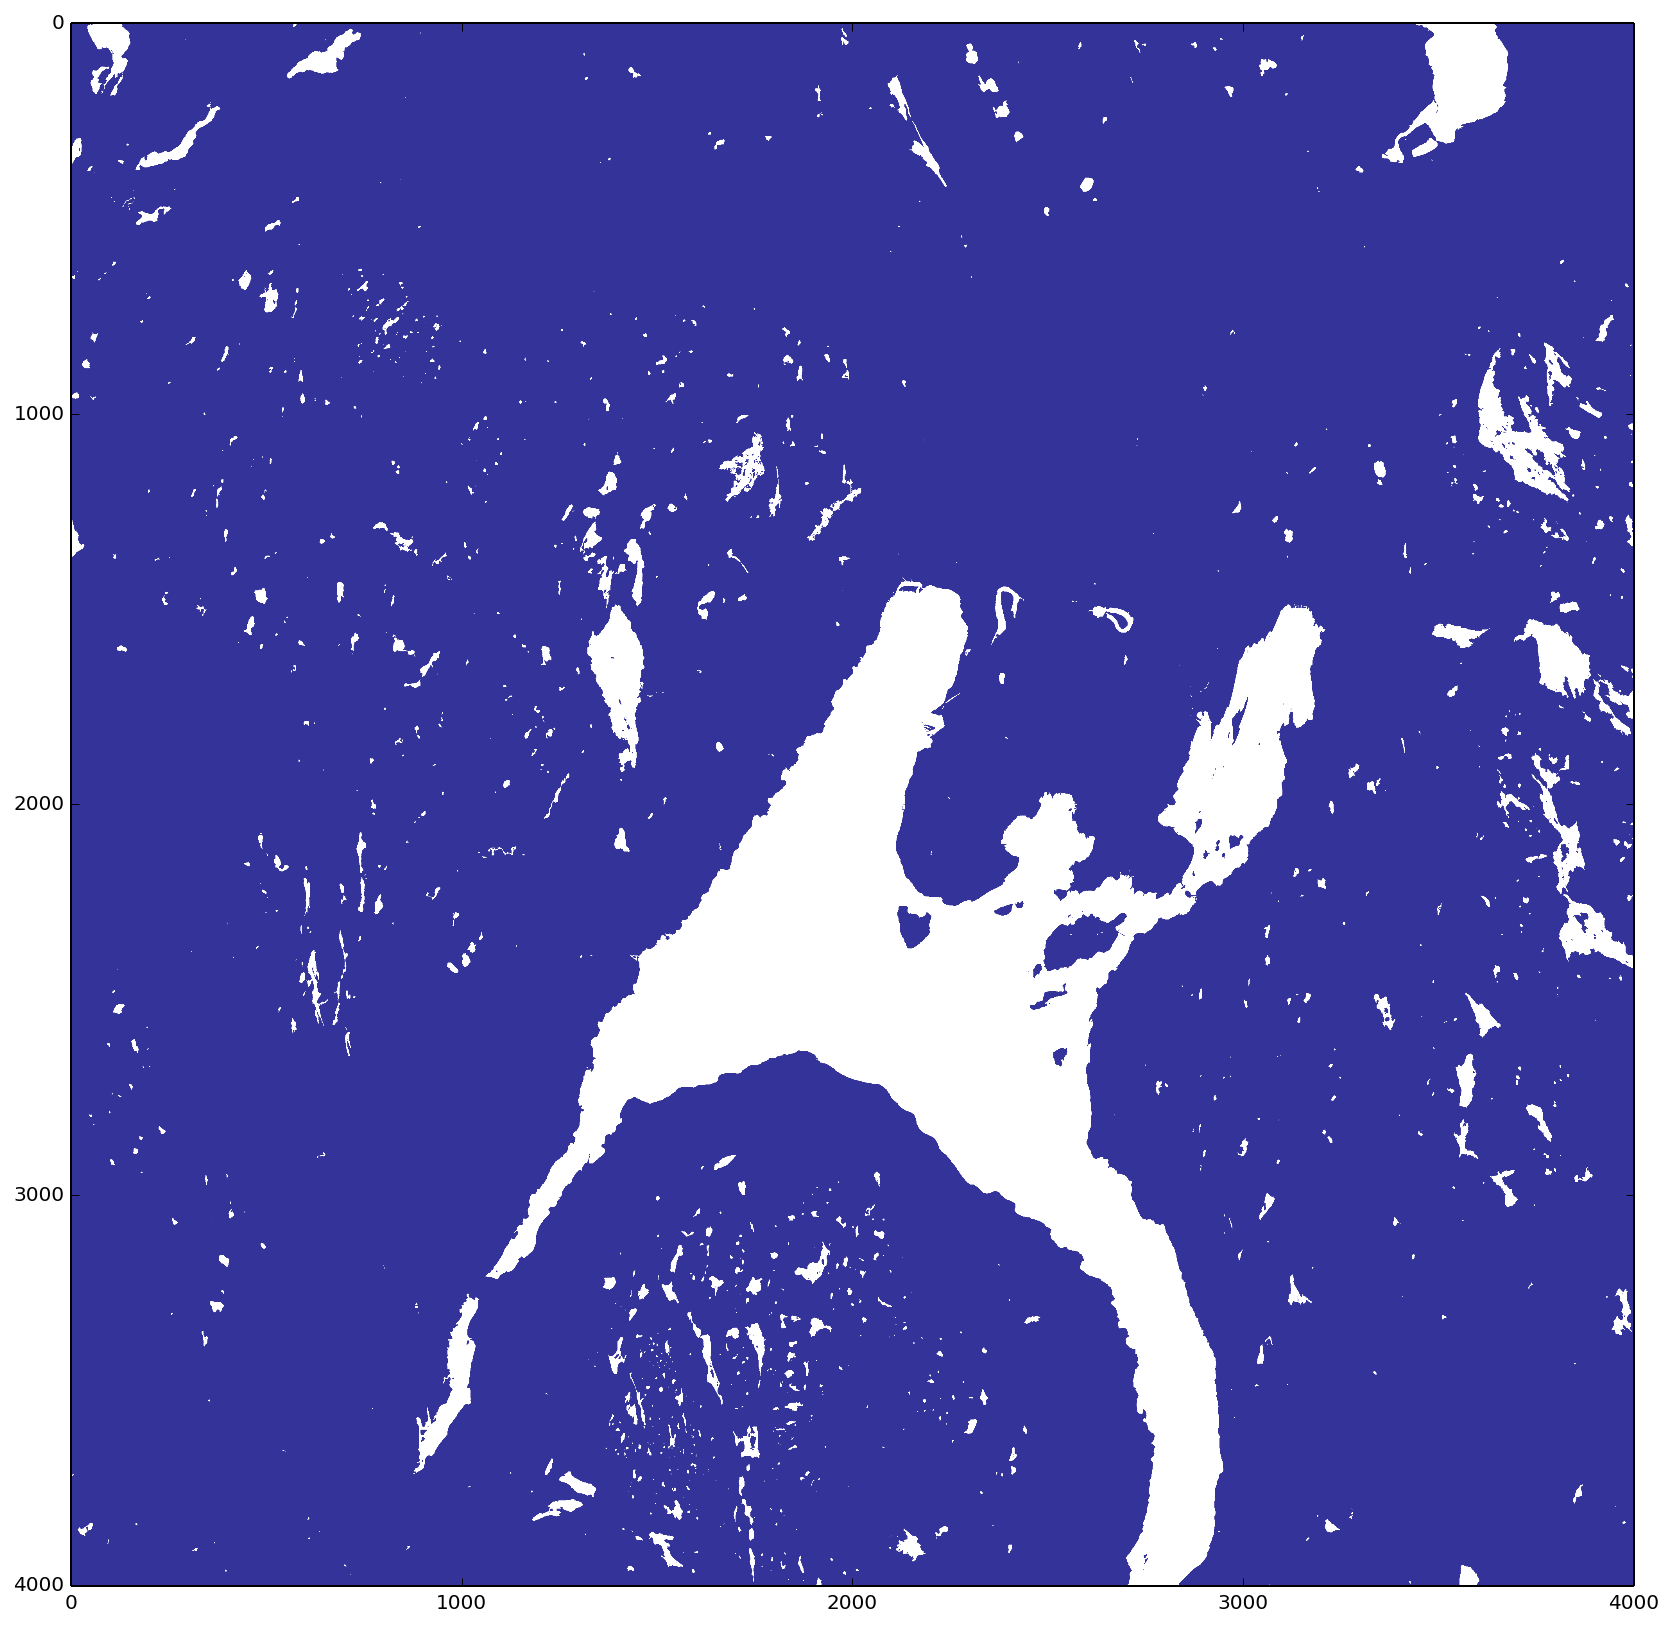

In [35]:
connstr = "host='127.0.0.1' dbname='n50' user='postgres' password='postgres'"

sql = bboxSql + """
 SELECT
  ST_AsTiff(ST_Union(ST_AsRaster(ST_Intersection(areal.GEOMETRI, bbox.geom), bbox.rast, '1BB', 1, ST_BandNoDataValue(bbox.rast), false)))
 FROM 
  n50.n50_arealdekkeflate as areal,
  bbox
 WHERE
  areal.objtype = 'Innsjø'
 AND
  areal.GEOMETRI && bbox.geom
"""

hav_filename = "anders_innsjo.tiff"

sqlToGeotiff(connstr, sql, hav_filename)

#Plot
plt.figure()
previewGeotiff(hav_filename)
plt.axes().autoscale(tight=True)
plt.axes().set_aspect('equal')
#plt.colorbar()
plt.show()

SQL query took 2.85698485374 seconds
Data size: 15 Mb
Wrote anders_myr.tiff, elapsed = 2.89134287834
Opening anders_myr.tiff
Geotiff size: (4002, 4001), extent: [209995.0, 250005.0, 6649985.0, 6690005.0]
16M active elements (16012002)


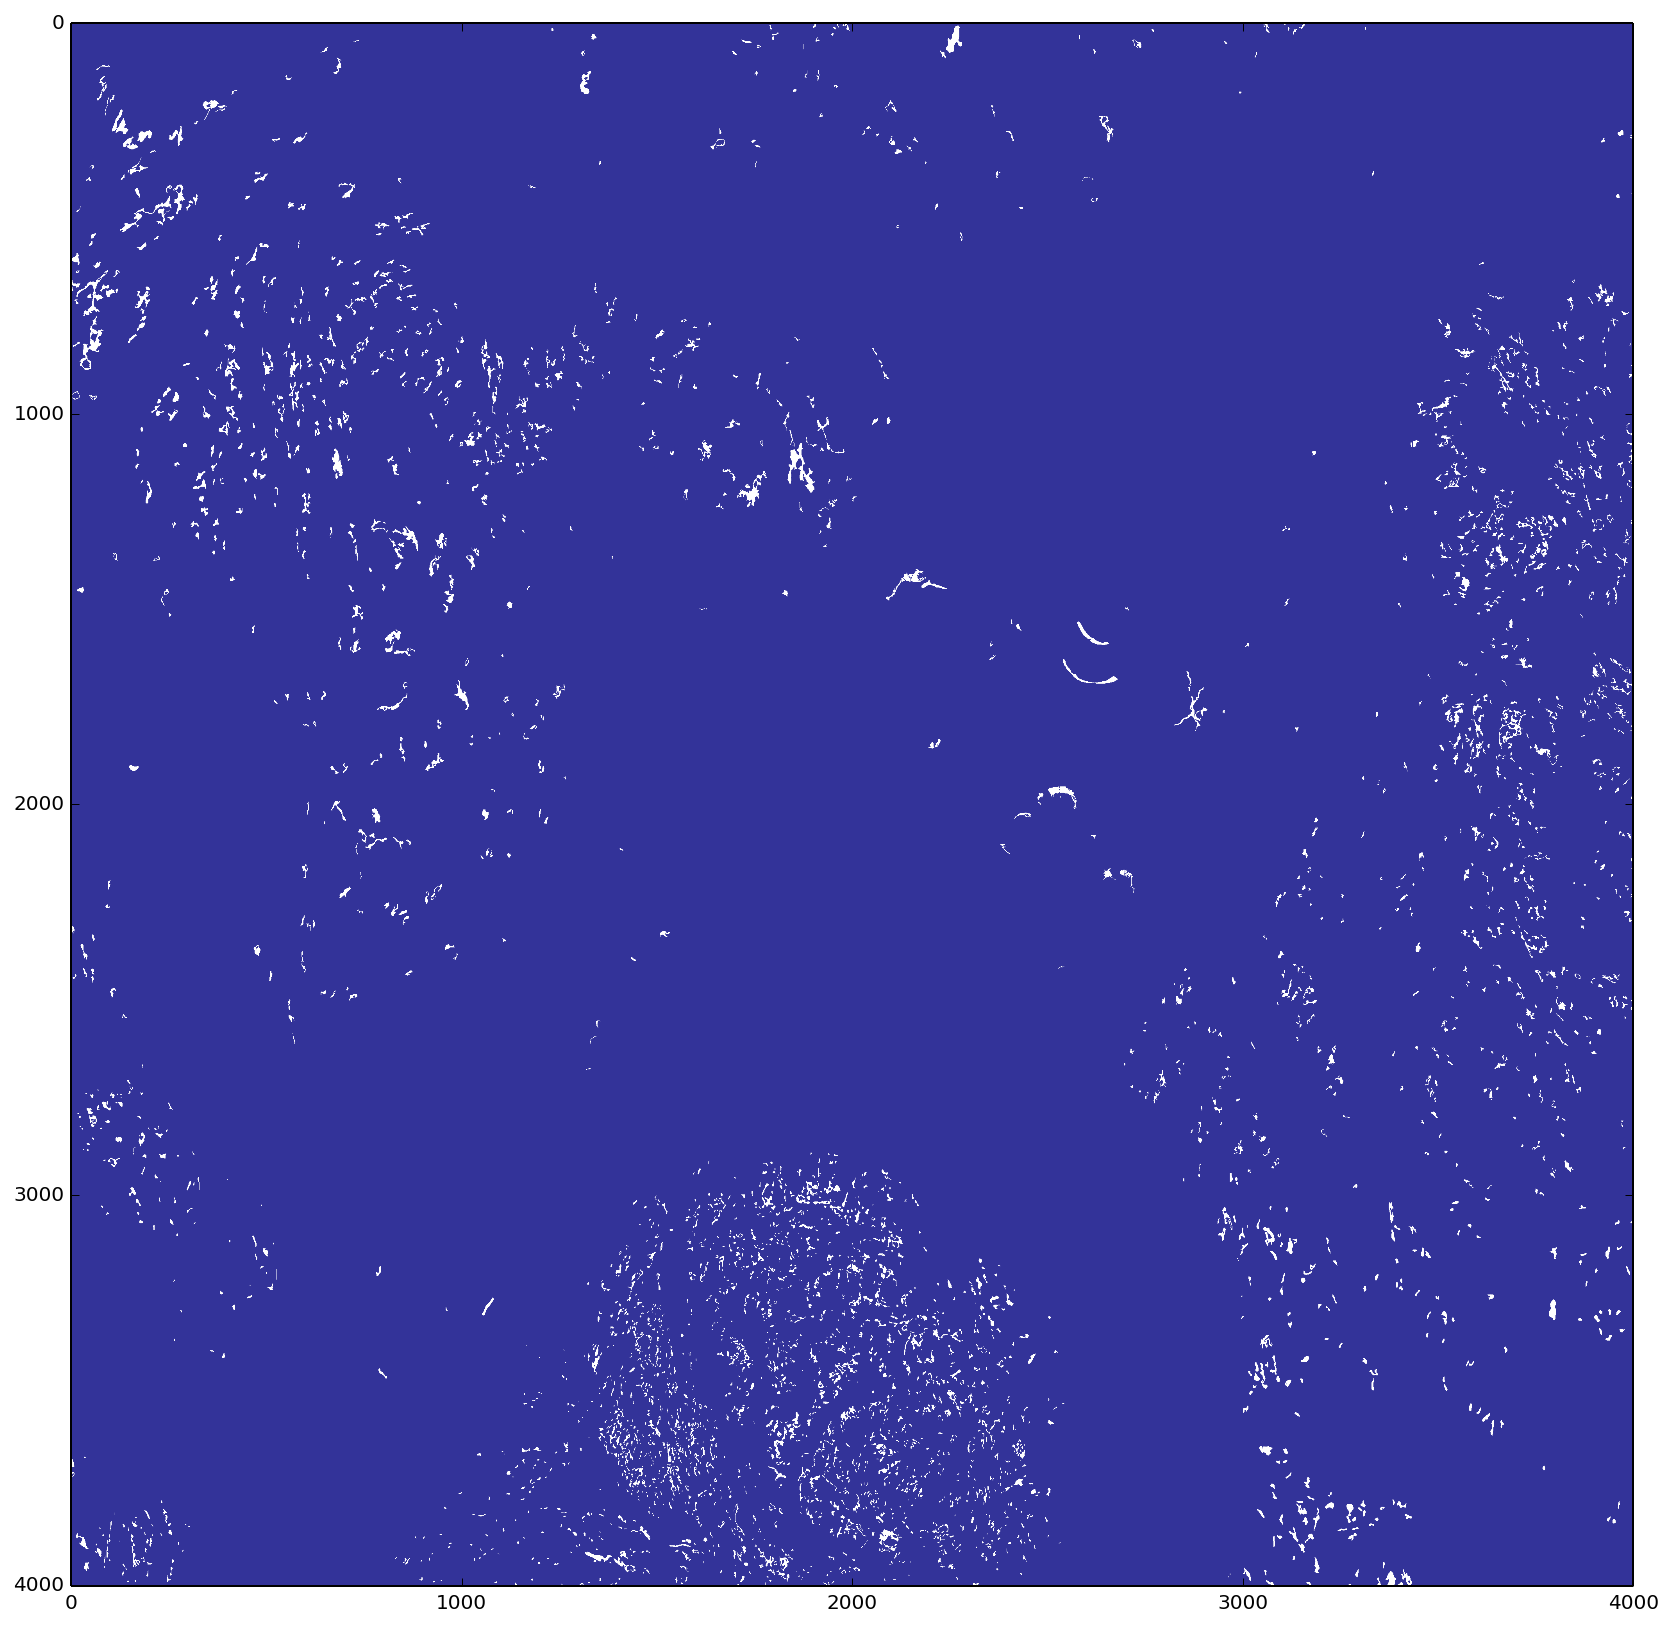

In [37]:
connstr = "host='127.0.0.1' dbname='n50' user='postgres' password='postgres'"

sql = bboxSql + """
 SELECT
  ST_AsTiff(ST_Union(ST_AsRaster(ST_Intersection(areal.GEOMETRI, bbox.geom), bbox.rast, '1BB', 1, ST_BandNoDataValue(bbox.rast), false)))
 FROM 
  n50.n50_arealdekkeflate as areal,
  bbox
 WHERE
  areal.objtype = 'Myr'
 AND
  areal.GEOMETRI && bbox.geom
"""

hav_filename = "anders_myr.tiff"

sqlToGeotiff(connstr, sql, hav_filename)

#Plot
plt.figure()
previewGeotiff(hav_filename)
plt.axes().autoscale(tight=True)
plt.axes().set_aspect('equal')
#plt.colorbar()
plt.show()

SQL query took 4.21069192886 seconds
Data size: 15 Mb
Wrote anders_elvmidtlinje.tiff, elapsed = 4.24437189102
Opening anders_elvmidtlinje.tiff
Geotiff size: (4002, 4002), extent: [209995.0, 250015.0, 6649985.0, 6690005.0]
16M active elements (16016004)


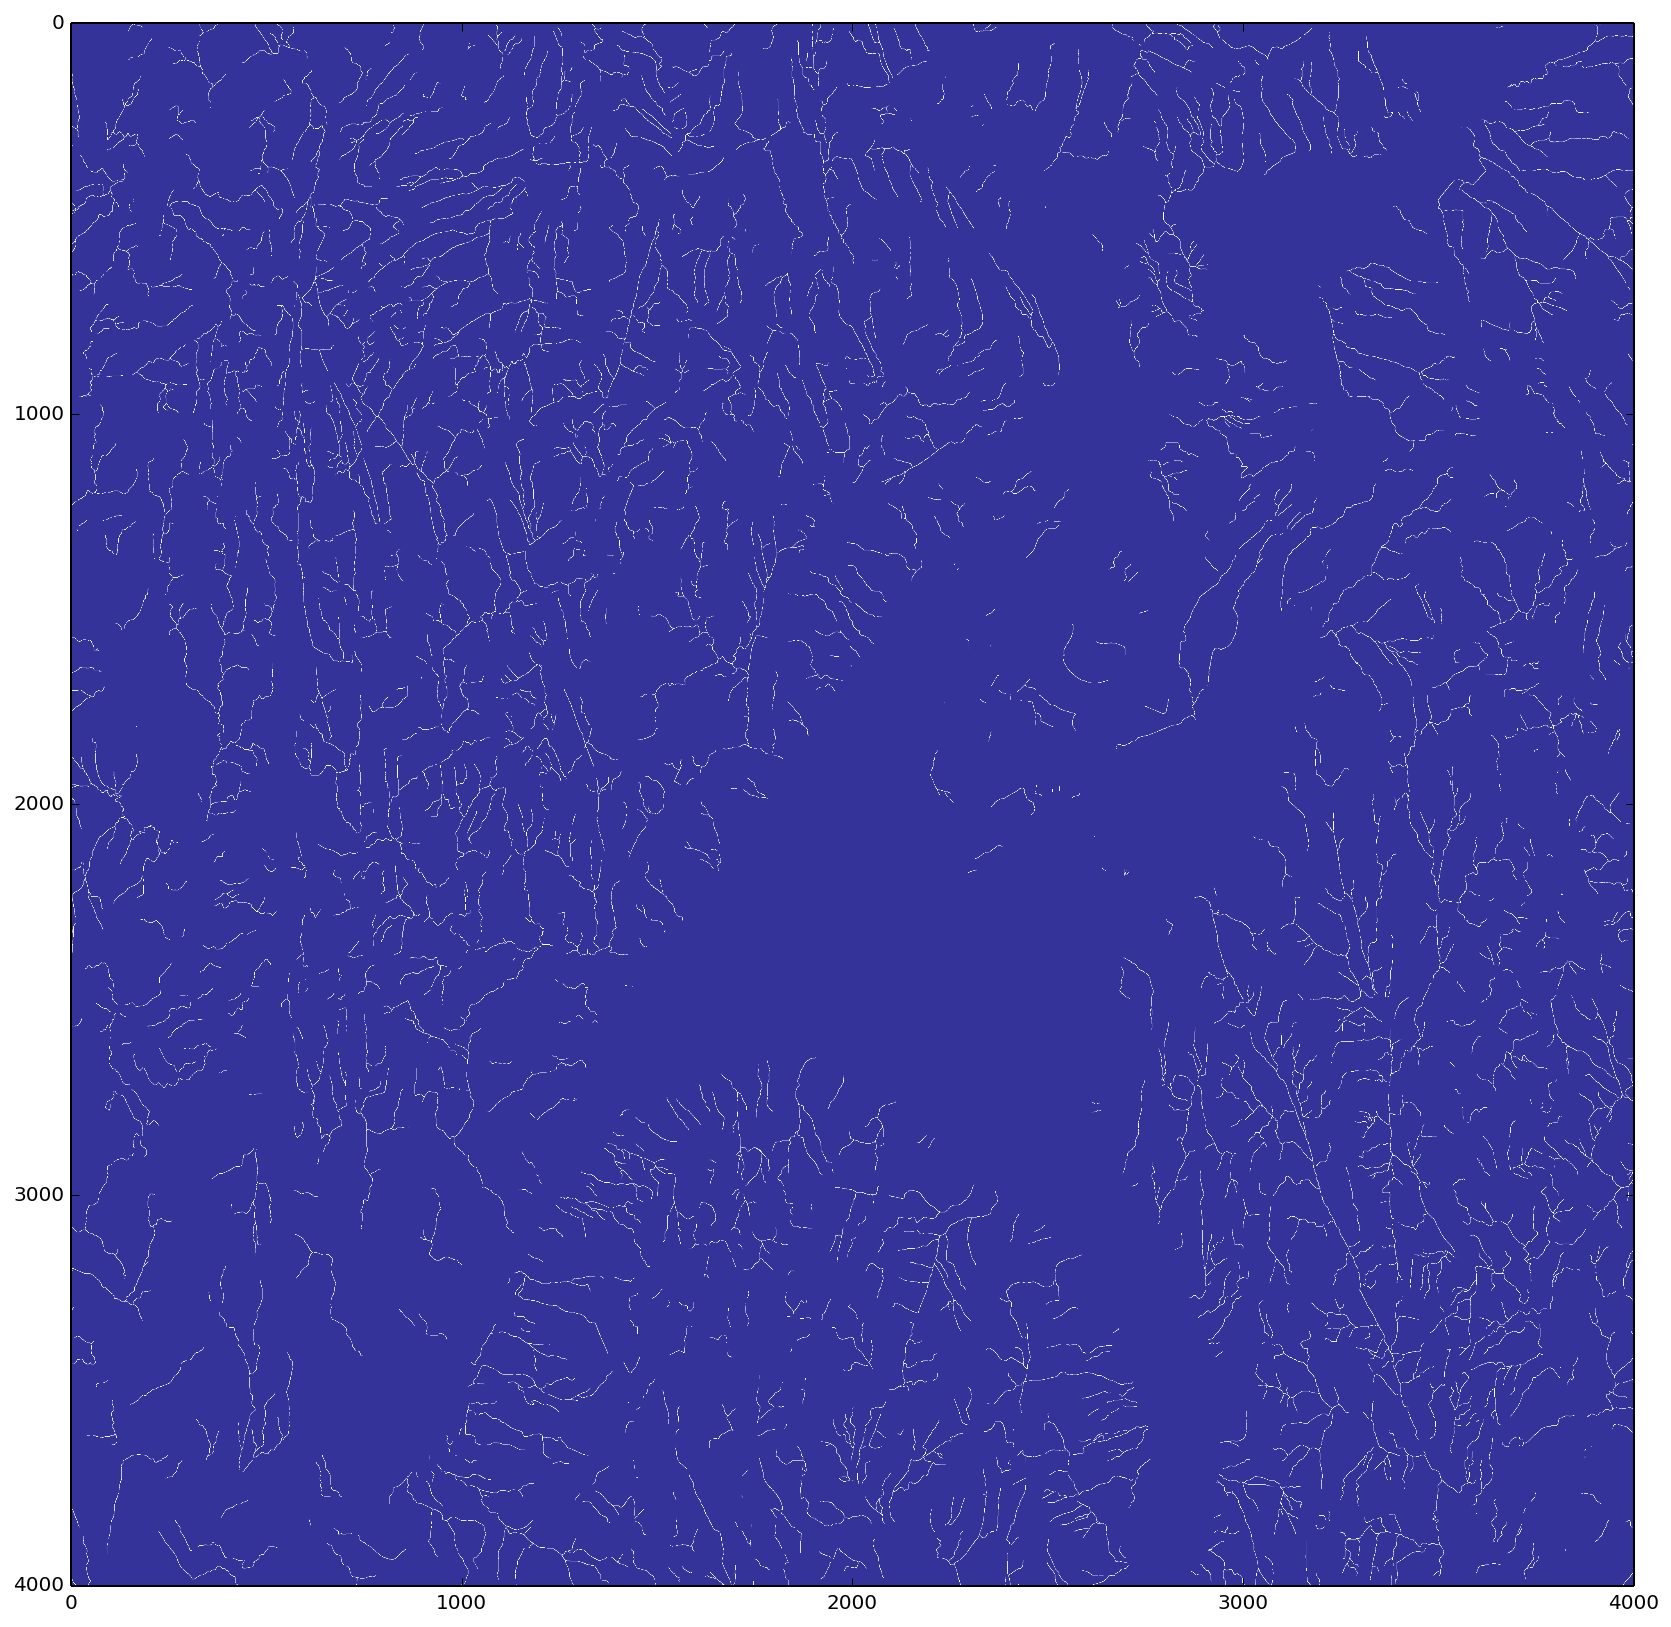

In [39]:
connstr = "host='127.0.0.1' dbname='n50' user='postgres' password='postgres'"

sql = bboxSql + """
 SELECT
  ST_AsTiff(ST_Union(ST_AsRaster(ST_Intersection(areal.GEOMETRI, bbox.geom), bbox.rast, '1BB', 1, ST_BandNoDataValue(bbox.rast), true)))
 FROM 
  n50.n50_elvbekk as areal,
  bbox
 WHERE
  areal.GEOMETRI && bbox.geom
"""

hav_filename = "anders_elvmidtlinje.tiff"

sqlToGeotiff(connstr, sql, hav_filename)

#Plot
plt.figure()
previewGeotiff(hav_filename)
plt.axes().autoscale(tight=True)
plt.axes().set_aspect('equal')
#plt.colorbar()
plt.show()